In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,root_mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import StackingRegressor
import warnings

# Import necessary libraries
warnings.filterwarnings("ignore")


# Load dataset
data = pd.read_csv('/content/food_wastage_data.csv')
data.head(10)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


,Type of Food,Number of Guests,Event Type,Quantity of Food,Storage Conditions,Purchase History,Seasonality,Preparation Method,Geographical Location,Pricing,Wastage Food Amount
0,Meat,310,Corporate,450,Refrigerated,Regular,All Seasons,Buffet,Urban,Low,25
1,Meat,400,Birthday,500,Room Temperature,Regular,Winter,Buffet,Suburban,High,40
2,Vegetables,302,Birthday,371,Refrigerated,Regular,Summer,Buffet,Suburban,Low,27
3,Meat,491,Birthday,497,Refrigerated,Regular,All Seasons,Finger Food,Rural,High,32
4,Meat,300,Corporate,400,Refrigerated,Regular,Winter,Finger Food,Urban,Moderate,25
5,Meat,302,Birthday,371,Refrigerated,Regular,Summer,Buffet,Suburban,Low,27
6,Meat,240,Wedding,450,Refrigerated,Regular,Winter,Sit-down Dinner,Urban,Low,20
7,Meat,300,Wedding,400,Refrigerated,Regular,Summer,Finger Food,Rural,Moderate,25
8,Fruits,320,Corporate,400,Refrigerated,Regular,All Seasons,Buffet,Urban,High,45
9,Meat,400,Corporate,500,Refrigerated,Occasional,Winter,Finger Food,Urban,High,40


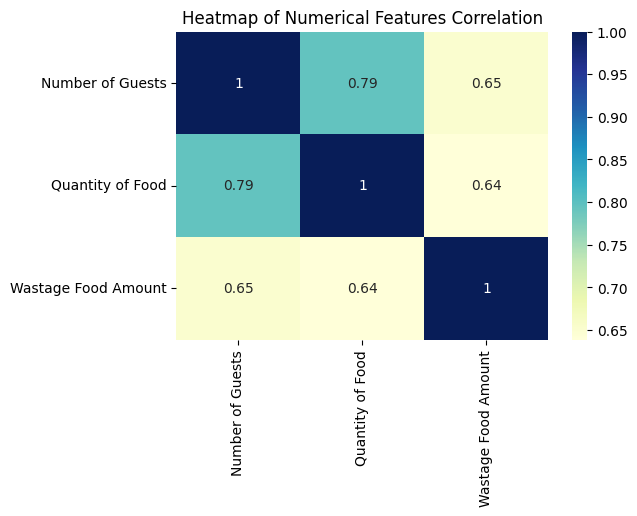

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap to show correlation between numerical features
plt.figure(figsize=(6,4))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="YlGnBu")
plt.title('Heatmap of Numerical Features Correlation')
plt.show()


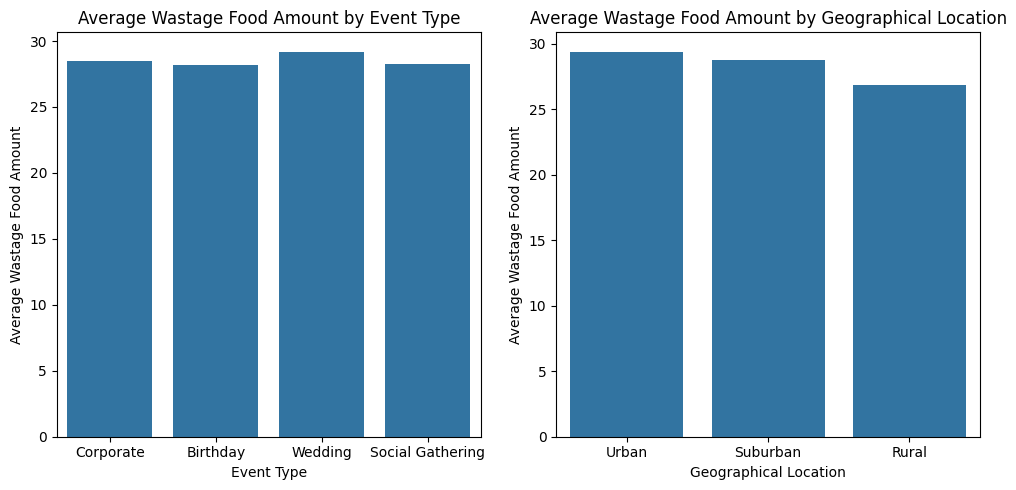

In [ ]:
# prompt: insert both the above bar graphs side by side

import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# First subplot: Average wastage by event type
sns.barplot(x='Event Type', y='Wastage Food Amount', data=data, ci=None, ax=axes[0])
axes[0].set_title('Average Wastage Food Amount by Event Type')
axes[0].set_ylabel('Average Wastage Food Amount')
axes[0].set_xlabel('Event Type')

# Second subplot: Average wastage by geographical location
sns.barplot(x='Geographical Location', y='Wastage Food Amount', data=data, ci=None, ax=axes[1])
axes[1].set_title('Average Wastage Food Amount by Geographical Location')
axes[1].set_ylabel('Average Wastage Food Amount')
axes[1].set_xlabel('Geographical Location')


# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [ ]:
X = data.drop('Wastage Food Amount', axis=1)
y = data['Wastage Food Amount']

# Identify categorical and numerical features
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing before feature selection
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [ ]:
# Random Forest Regressor for feature selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
import numpy as np

# Initialize the Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42)

# Recursive Feature Elimination (RFE) for feature selection
# Adjust n_features_to_select as per your requirement
rfe = RFE(estimator=rfr, n_features_to_select=10)

# Fit RFE on the preprocessed training data
X_train_rfe = rfe.fit_transform(X_train_processed, y_train)

# Transform the test data using the selected features
X_test_rfe = rfe.transform(X_test_processed)

# Get the indices of the selected features for RFE
selected_features_rfe_indices = np.where(rfe.support_)[0]

# Get the names of the selected features
# Ensure 'preprocessor' has the correct feature names
feature_names = preprocessor.get_feature_names_out()
selected_features_rfe = [feature_names[i] for i in selected_features_rfe_indices]

# Output the selected feature names after RFE
print("Selected Features using RFE:")
print(selected_features_rfe)


Selected Features using RFE:
['num__Number of Guests', 'num__Quantity of Food', 'cat__Preparation Method_Buffet', 'cat__Preparation Method_Finger Food', 'cat__Preparation Method_Sit-down Dinner', 'cat__Geographical Location_Rural', 'cat__Geographical Location_Urban', 'cat__Pricing_High', 'cat__Pricing_Low', 'cat__Pricing_Moderate']


In [ ]:

# Dictionary to store evaluation metrics for each model
metrics = {}

# Ensemble models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42),
    'Bagging Regressor': BaggingRegressor(n_estimators=100, random_state=42)

}


# Create a list of estimators for stacking
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('lgbm', lgb.LGBMRegressor(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBRegressor(n_estimators=100, random_state=42)),
    ('et', ExtraTreesRegressor(n_estimators=100, random_state=42)),
    ('bag', BaggingRegressor(n_estimators=100, random_state=42))
]

# Create a stacking regressor:
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=100, random_state=42)
)

# Add stacking regressor to the models dictionary
models['Stacking Regressor'] = stacking_regressor

for model_name, model in models.items():
    # Train model on RFE selected features
    model.fit(X_train_rfe, y_train)
    y_pred_rfe = model.predict(X_test_rfe)

    # Evaluate model on RFE selected features
    mse_rfe = mean_squared_error(y_test, y_pred_rfe)
    r2_rfe = r2_score(y_test, y_pred_rfe)
    mae_rfe = mean_absolute_error(y_test, y_pred_rfe)
    rmse_rfe = np.sqrt(mse_rfe)

    metrics[model_name] = {
        'RFE': {'MSE': mse_rfe, 'R2': r2_rfe, 'MAE': mae_rfe, 'RMSE': rmse_rfe},
    }


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 1425, number of used features: 10
[LightGBM] [Info] Start training from score 28.708772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 1425, number of used features: 10
[LightGBM] [Info] Start training from score 28.708772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

In [ ]:
# Create a table to display the evaluation metrics for each model
results_df = pd.DataFrame({
    'Model': list(metrics.keys()),
    'MSE ': [metrics[model]['RFE']['MSE'] for model in metrics],
    'MAE ': [metrics[model]['RFE']['MAE'] for model in metrics],
    'R2 ': [metrics[model]['RFE']['R2'] for model in metrics],
    'RMSE': [metrics[model]['RFE']['RMSE'] for model in metrics],
})

# Display the table
print(results_df)


                Model      MSE       MAE        R2       RMSE
0       Random Forest  7.147123  1.542729  0.931051  2.673410
1   Gradient Boosting  8.904335  2.230108  0.914099  2.984013
2            LightGBM  7.482658  1.785939  0.927814  2.735445
3             XGBoost  7.185990  1.521036  0.930676  2.680670
4         Extra Trees  7.232978  1.526639  0.930223  2.689420
5   Bagging Regressor  7.139497  1.543352  0.931124  2.671984
6  Stacking Regressor  7.441588  1.559182  0.928210  2.727928


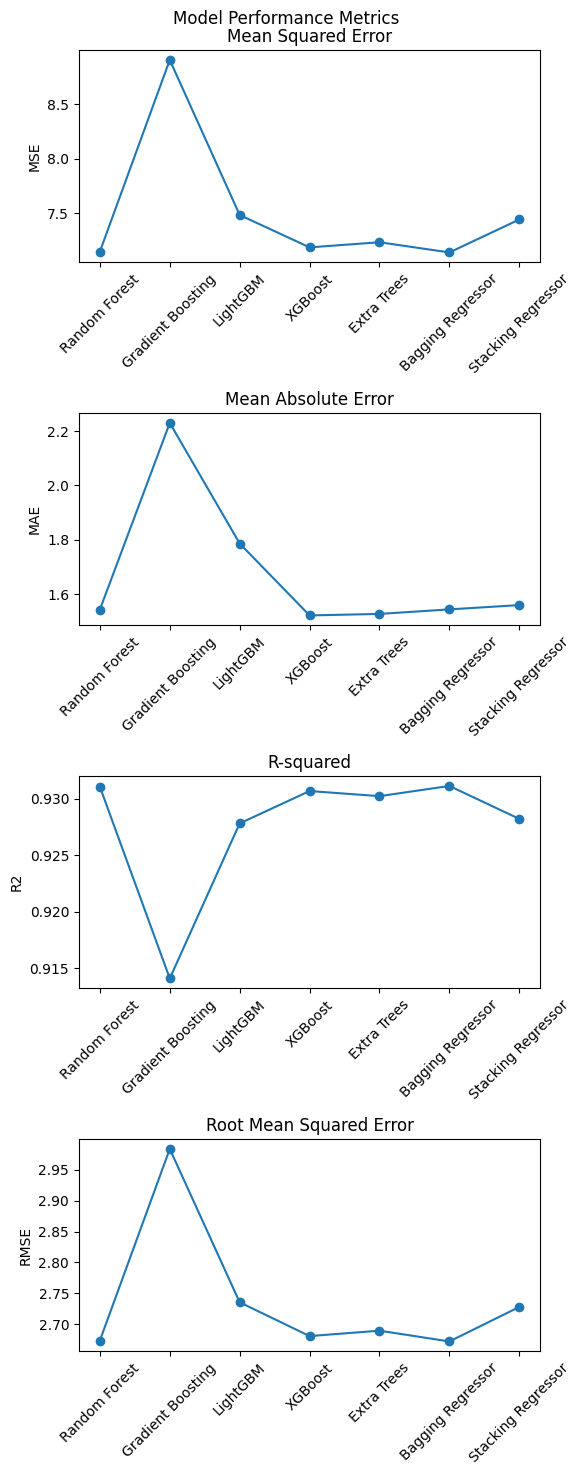

In [ ]:

# Extract the metrics for plotting
models = results_df['Model'].tolist()
mse_values = results_df['MSE '].tolist()
mae_values = results_df['MAE '].tolist()
r2_values = results_df['R2 '].tolist()
rmse_values = results_df['RMSE'].tolist()

# Create subplots for each metric
fig, axs = plt.subplots(4, 1, figsize=(6, 15))  # Reduced width to 6
fig.suptitle('Model Performance Metrics')

# Plot MSE
axs[0].plot(models, mse_values, marker='o', linestyle='-')
axs[0].set_ylabel('MSE')
axs[0].set_title('Mean Squared Error')
axs[0].tick_params(axis='x', rotation=45)

# Plot MAE
axs[1].plot(models, mae_values, marker='o', linestyle='-')
axs[1].set_ylabel('MAE')
axs[1].set_title('Mean Absolute Error')
axs[1].tick_params(axis='x', rotation=45)


# Plot R2
axs[2].plot(models, r2_values, marker='o', linestyle='-')
axs[2].set_ylabel('R2')
axs[2].set_title('R-squared')
axs[2].tick_params(axis='x', rotation=45)


# Plot RMSE
axs[3].plot(models, rmse_values, marker='o', linestyle='-')
axs[3].set_ylabel('RMSE')
axs[3].set_title('Root Mean Squared Error')
axs[3].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()


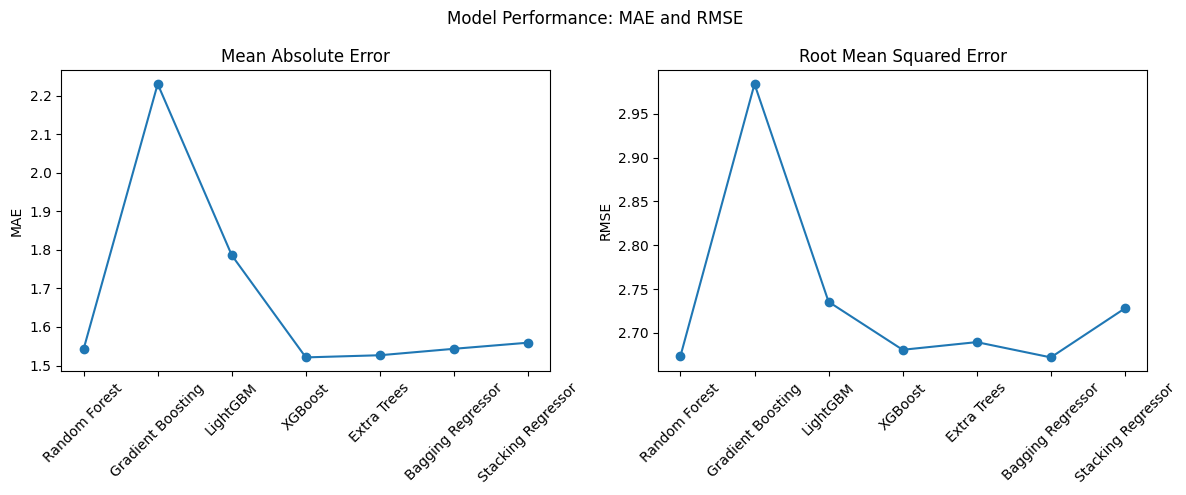

In [ ]:
# Extract the metrics for plotting
models = results_df['Model'].tolist()
mae_values = results_df['MAE '].tolist()
rmse_values = results_df['RMSE'].tolist()

# Create subplots for MAE and RMSE side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Reduced width to 6
fig.suptitle('Model Performance: MAE and RMSE')

# Plot MAE
axs[0].plot(models, mae_values, marker='o', linestyle='-')
axs[0].set_ylabel('MAE')
axs[0].set_title('Mean Absolute Error')
axs[0].tick_params(axis='x', rotation=45)

# Plot RMSE
axs[1].plot(models, rmse_values, marker='o', linestyle='-')
axs[1].set_ylabel('RMSE')
axs[1].set_title('Root Mean Squared Error')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


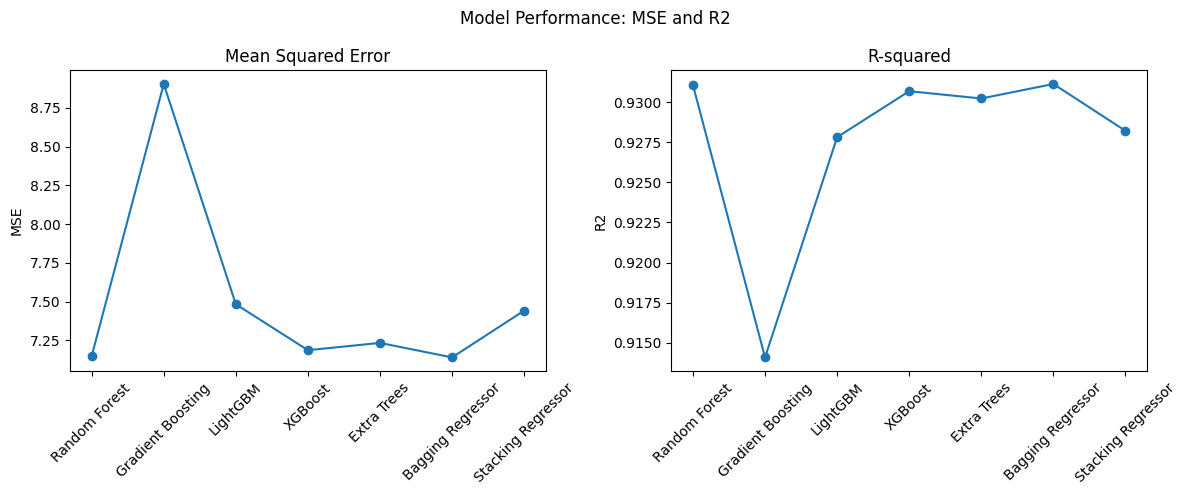

In [ ]:
# Extract the metrics for plotting
models = results_df['Model'].tolist()
mse_values = results_df['MSE '].tolist()
r2_values = results_df['R2 '].tolist()

# Create subplots for MSE and R2 side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Reduced width to 6
fig.suptitle('Model Performance: MSE and R2')

# Plot MSE
axs[0].plot(models, mse_values, marker='o', linestyle='-')
axs[0].set_ylabel('MSE')
axs[0].set_title('Mean Squared Error')
axs[0].tick_params(axis='x', rotation=45)

# Plot R2
axs[1].plot(models, r2_values, marker='o', linestyle='-')
axs[1].set_ylabel('R2')
axs[1].set_title('R-squared')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
